In [1]:
import openferro as of
from openferro.interaction import *
from openferro.simulation import *
from openferro.engine import *
from openferro.ewald import get_dipole_dipole_ewald
from matplotlib import pyplot as plt
import json


In [5]:
L = 12
config = json.load(open('../model_configs/BaTiO3.json'))
latt_vecs = jnp.eye(3) * config['lattice']['a1']
latt = of.BravaisLattice3D(L, L, L, latt_vecs[0], latt_vecs[1], latt_vecs[2])
bto = of.System(latt, pbc=True)

## define fields
dipole_field = bto.add_field(name="dipole", ftype="Rn", dim=3, value=0.1, mass = 40)
lstrain_field = bto.add_field(name="lstrain", ftype="local_strain", value=0.0, mass = 40)
gstrain_field = bto.add_field(name="gstrain", ftype="global_strain", value=jnp.zeros(6), mass = 10000)

## define Hamiltonian
bto.add_self_interaction('self_onsite', field_name="dipole", energy_engine=self_energy_onsite_isotropic, parameters=config["onsite"], enable_jit=True)
bto.add_self_interaction('short_range_1', field_name="dipole", energy_engine=short_range_1stnn_isotropic, parameters=config["short_range"], enable_jit=True)
bto.add_self_interaction('short_range_2', field_name="dipole", energy_engine=short_range_2ednn_isotropic, parameters=config["short_range"], enable_jit=True)
bto.add_self_interaction('short_range_3', field_name="dipole", energy_engine=short_range_3rdnn_isotropic, parameters=config["short_range"], enable_jit=True)
bto.add_self_interaction('dipole_dipole', field_name="dipole", energy_engine=get_dipole_dipole_ewald(latt), parameters=config["born"], enable_jit=True)


homo_config = config["elastic"].copy()
homo_config['N'] = L**3
bto.add_self_interaction('homo_elastic', field_name="gstrain", energy_engine=homo_elastic_energy, parameters=homo_config, enable_jit=True)
bto.add_mutual_interaction('homo_strain_dipole', field_name1="gstrain", field_name2="dipole", energy_engine=homo_strain_dipole_interaction, parameters=config["elastic_dipole"], enable_jit=True)

# bto.add_mutual_interaction('elastic', field_name1="lstrain", field_name2="gstrain", energy_engine=elastic_energy, parameters=config["elastic"], enable_jit=True)
# bto.add_mutual_interaction('inhomo_strain_dipole', field_name1="lstrain", field_name2="dipole", energy_engine=inhomo_strain_dipole_interaction, parameters=config["elastic_dipole"], enable_jit=True)

interaction_name = []
for interaction in bto._self_interaction_dict:
    interaction_name.append(interaction)
for interaction in bto._mutual_interaction_dict:
    interaction_name.append(interaction)


In [6]:

print('mass:', bto.get_field_by_name('dipole').get_mass().flatten())
bto.update_force()
print('max force before optimization',jnp.abs(bto.get_field_by_name("dipole").get_force()).max())
print('average field before optimization',bto.get_field_by_name("dipole").get_values().mean())
for interaction in interaction_name:
    print('E({})={}eV'.format( interaction, bto.calc_energy_by_name(interaction)))
    # %timeit bto.calc_energy_by_name(interaction)
    # %timeit bto.calc_force_by_name(interaction)
print('total E:{}eV'.format(bto.calc_potential_energy()))
minimizer = MDMinimize(bto, max_iter=200, tol=1e-5, dt=0.01)
minimizer.minimize()

equilibrium_field = bto.get_field_by_name("dipole").get_values().copy()
print('max force after optimization',jnp.abs(bto.get_field_by_name("dipole").get_force()).max())
print('average field after optimization',bto.get_field_by_name("dipole").get_values().mean())
print('global strain:', bto.get_field_by_name("gstrain").get_values())
for interaction in interaction_name:
    print('E({})={}eV'.format( interaction, bto.calc_energy_by_name(interaction)))
print('total E:{}eV'.format(bto.calc_potential_energy()))

# print('field:', equilibrium_field[:2,:2,:2])

mass: [40. 40. 40. ... 40. 40. 40.]
max force before optimization 0.32748342
average field before optimization 0.10000395
E(pV)=0.0eV
E(self_onsite)=372.3564453125eV
E(short_range_1)=-72.66571044921875eV
E(short_range_2)=104.40586853027344eV
E(short_range_3)=74.23656463623047eV
E(dipole_dipole)=-480.23114013671875eV
E(homo_elastic)=0.0eV
E(homo_strain_dipole)=0.0eV
total E:-1.89794921875eV
max force after optimization 0.103109576
average field after optimization 0.09310832
global strain: [[[[0.00503526 0.00501332 0.00501333 0.00134342 0.00134483 0.00134482]]]]
E(pV)=0.0eV
E(self_onsite)=312.75262451171875eV
E(short_range_1)=-63.01746368408203eV
E(short_range_2)=90.52005767822266eV
E(short_range_3)=64.3548583984375eV
E(dipole_dipole)=-417.28143310546875eV
E(homo_elastic)=14.335144996643066eV
E(homo_strain_dipole)=-28.62703514099121eV
total E:-26.963245391845703eV


In [7]:
# temp_list = [ 20,40,60,80,100,120,140]
temp_list = [20]
# average_field = np.zeros(len(temp_list))
log_freq = 100
total_time = 10
dt = 0.002
relax_steps = int(10/dt)
total_steps = int(total_time / dt)
niters = total_steps // log_freq
field_history = []
for it, temperature in enumerate(temp_list):
    # simulation = SimulationNVTLangevin(bto, dt=dt, temperature=temperature, tau=0.1)
    simulation = SimulationNPTLangevin(bto, dt=dt, temperature=temperature, pressure=-4.8e4, tau=0.1, tauP= 1)
    # simulation.system.get_field_by_name('dipole').set_values(equilibrium_field.copy())
    simulation.init_velocity(mode='gaussian')
    simulation.step(relax_steps)
    print('T={}K'.format(temperature))
    average_field = []
    excess_stress_list = []
    for ii in range(niters):
        simulation.step(log_freq)
        # print('velocity:', bto.get_field_by_name('dipole').get_velocity().flatten())
        # print('field:', bto.get_field_by_name('dipole').get_values().flatten())
        pot_E = bto.calc_potential_energy()
        kin_E = bto.calc_kinetic_energy()
        total_E = pot_E + kin_E
        # average_field[it] += bto.get_field_by_name('dipole').get_values().mean() / niters
        average_field.append(bto.get_field_by_name('dipole').get_values().mean())
        excess_stress = bto.calc_excess_stress().flatten()
        excess_stress_list.append(excess_stress)
        print('=================T={}K, iter={}======================='.format(temperature, ii))
        # print('pot energy:', pot_E)
        # print('kine energy:', kin_E)
        # print('total energy:', total_E)
        print('temperature:', bto.calc_temp_by_name('dipole'))
        print('average field:', average_field[-1])
        print('excessive stress [bar]', excess_stress)
        # print('field:', bto.get_field_by_name('dipole').get_values().flatten())
    field_history.append(average_field)
field_history = jnp.array(field_history)
excess_stress_list = jnp.array(excess_stress_list)


T=20K
=================T=20K, iter=0=======================
temperature: 19.980831
average field: 0.096480615
excessive stress [bar] [ 455.1818   347.20615  220.19539 -164.33046 -105.56161 -319.37936]
=================T=20K, iter=1=======================
temperature: 19.830204
average field: 0.09657237
excessive stress [bar] [ 216.86037     144.52153     -78.00802     -49.329025      0.55760026
 -146.18745   ]
=================T=20K, iter=2=======================
temperature: 19.902483
average field: 0.09662521
excessive stress [bar] [-230.94797  -249.90039  -422.7202     26.04365    99.236885   37.772423]
=================T=20K, iter=3=======================
temperature: 20.172754
average field: 0.096691094
excessive stress [bar] [-230.27214 -203.10332 -324.2263    74.95695  212.69948  121.87021]
=================T=20K, iter=4=======================
temperature: 19.3678
average field: 0.09675374
excessive stress [bar] [356.43442  178.09048  232.99747   16.376093 234.04428  159.9306  ]

In [17]:
excess_stress_list.mean(0) 

Array([ 27.823393 ,  -2.4253612, -23.463861 ,  14.503721 ,   4.3305273,
       -19.690302 ], dtype=float32)

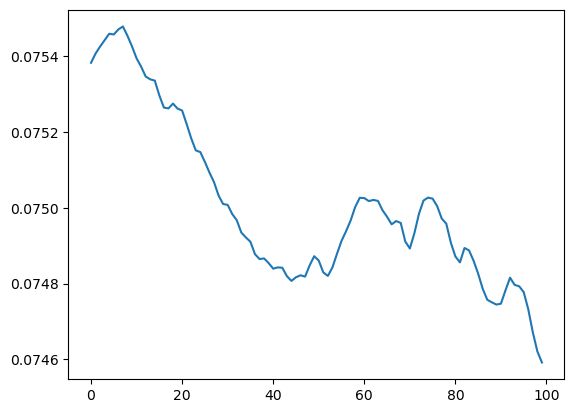

In [23]:
plt.plot(field_history[6], label='20K')
# field_history.shape